In [50]:
import os
import numpy as np
import theano
import theano.tensor as T
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sklearn.datasets
%matplotlib inline

In [51]:
np.random.seed(0)
nn_hdim = 4
epsilon = 1e-4 # learning rate for gradient descent
reg_lambda = 0.01
size = "100k"

In [ ]:
def get_data(data_size):
    ratings = []
    if size == "100k":
        path = os.path.join("Data", "ml-100k", "u.data")
        print("Read movie lens 100k data set")
        f = open(path, "r")
        while (1):
            line = f.readline()
            if line == "":
                break
            ratings.append(line.split()[0:-1])
        f.close()
    if size == "1m" or size == "10m":
        path = os.path.join("Data", "ml-" + size, "ratings.dat")
        print("Read movie lens " + size + " data set")
        f = open(path, "r")
        while (1):
            line = f.readline()
            if line == "":
                break
            ratings.append(line.split("::")[0:-1])
        f.close()
    if size == "20m":
        path = os.path.join("Data", "ml-20m", "ratings.csv")
        print("Read movie lens 20m data set")
        f = open(path, "r")
        line = f.readline()
        while (1):
            line = f.readline()
            if line == "":
                break
            ratings.append(line.split(",")[0:-1])
        f.close()
    ratings = np.array(ratings, dtype = np.float32)
    # permute the ratings array
    ratings = np.random.permutation(ratings)
    print("Loading data done")
    return ratings

In [ ]:
def load_split_data(data_size, test_p):
    # Load data and split into train set, test set randomly.
    # data_size is either "100k", "1m", "10m" or "20m".
    # test_p is a float between 0 - 1 indicating the portion of data hold out as test set
    print("split data randomly")
    # Load ratings, data is already permuted in get_data
    ratings = get_data(data_size)
    nb_users = int(np.max(ratings[:, 0]))
    nb_movies = int(np.max(ratings[:, 1]))
    # split test/train set
    test_size = int(len(ratings) * test_p)
    test_ratings = ratings[:test_size]
    train_ratings = ratings[test_size:]
    # train_ratings is converted into a matrix
    train_M = np.zeros((nb_movies, nb_users), dtype = np.float32)
    for rating in train_ratings:
        train_M[int(rating[1]-1), int(rating[0]-1)] = rating[2]
    # save test and train data in case more training is needed on this split
    np.save("Data/" + data_size + "_" + str(int(test_p * 100))+ "percent_test.npy", test_ratings)
    np.save("Data/" + data_size + "_" + str(int(test_p * 100))+ "percent_trainM.npy", train_M)
    # test_ratings is numpy array of user id | item id | rating
    # train_M is numpy array with nb_movies rows and nb_users columns, missing entries are filled with zero
    return test_ratings, train_M, nb_users, nb_movies, len(train_ratings)

In [ ]:
test_ratings, train_M, nb_users, nb_movies, k = load_split_data("100k", 0.1)

In [52]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

In [74]:
X = pd.read_csv("Data/wine_zeroone.csv",header=None).values

In [75]:
X_mask = X.copy()

In [76]:
X_mask[X != 0] =1

In [77]:
X.shape[1]

11

In [78]:
nn_input_dim = X.shape[1]
nn_output_dim = X.shape[1]

In [79]:
W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
b1 = np.zeros((1, nn_hdim))
W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
b2 = np.zeros((1, nn_output_dim))

In [80]:
W1.shape

(11, 4)

In [81]:
L = []
Flag = True
for i in xrange(0, 100):
    print i
#     if i > 600 and Flag:
#         epsilon *= 0.5
#         Flag = False

    # Forward propagation
    #print "W1:"
    #print W1
    z1 = X.dot(W1) + b1
    #print "z1:"
    #print z1
    a1 = sigmoid(z1)
    #print "a1"
    #print a1
    #print "W2"
    #print W2
    z2 = a1.dot(W2) + b2
    #print "z2"
    #print z2
    loss = np.sum(np.square(X - z2) * X_mask)
    loss += (reg_lambda/2) * (1.0/ X.shape[0]) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    L.append(loss)
    print "Loss: "
    print loss

    # Backpropagation
    delta3 = (z2 - X) * X_mask
    #print "delta3:"
    #print delta3
    dW2 = (a1.T).dot(delta3)
    #print "dw2:"
    #print dW2
    db2 = np.sum(delta3, axis=0, keepdims=True)
    #print "db2"
    #print db2
    delta2 = delta3.dot(W2.T) * a1 * (1 - a1)
    #print "delta2"
    #print delta2
    dW1 = np.dot((X * X_mask).T, delta2)
    #print "dw1"
    #print dW1
    db1 = np.sum(delta2, axis=0)
    #print "db1"
    #print db1
    # Add regularization terms (b1 and b2 don't have regularization terms)
    dW2 += reg_lambda * W2
    dW1 += reg_lambda * W1

    # Gradient descent parameter update
    W1 += -epsilon * dW1
    b1 += -epsilon * db1
    W2 += -epsilon * dW2
    b2 += -epsilon * db2

0
Loss: 
7393.3561847
1
Loss: 
3122.4595546
2
Loss: 
1473.16005037
3
Loss: 
775.107615151
4
Loss: 
467.112292796
5
Loss: 
328.330289818
6
Loss: 
265.065049092
7
Loss: 
236.017196568
8
Loss: 
222.607563204
9
Loss: 
216.381772862
10
Loss: 
213.466705894
11
Loss: 
212.080644676
12
Loss: 
211.401780412
13
Loss: 
211.050385078
14
Loss: 
210.850784569
15
Loss: 
210.721634769
16
Loss: 
210.625245212
17
Loss: 
210.544143082
18
Loss: 
210.470224621
19
Loss: 
210.399729774
20
Loss: 
210.330913064
21
Loss: 
210.262963647
22
Loss: 
210.1955044
23
Loss: 
210.128359519
24
Loss: 
210.061446668
25
Loss: 
209.99472691
26
Loss: 
209.928181473
27
Loss: 
209.861800949
28
Loss: 
209.79558029
29
Loss: 
209.729516473
30
Loss: 
209.663607423
31
Loss: 
209.597851511
32
Loss: 
209.532247317
33
Loss: 
209.466793525
34
Loss: 
209.401488872
35
Loss: 
209.336332121
36
Loss: 
209.271322056
37
Loss: 
209.206457474
38
Loss: 
209.141737181
39
Loss: 
209.077159994
40
Loss: 
209.012724737
41
Loss: 
208.948430244
42
Loss:

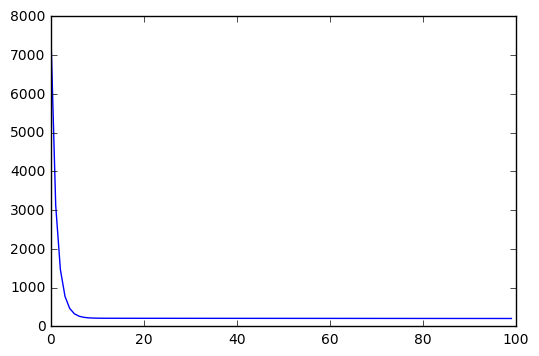

In [82]:
plt.plot(L)

In [83]:
X

array([[ 0.34615385,  0.25490196,  0.25301205, ...,  0.36363636,
         0.36046512,  0.53225806],
       [ 0.17307692,  0.30392157,  0.        , ...,  0.50909091,
         0.1627907 ,  0.        ],
       [ 0.46153846,  0.        ,  0.        , ...,  0.34545455,
         0.39534884,  0.4516129 ],
       ..., 
       [ 0.33653846,  0.14705882,  0.22289157, ...,  0.        ,
         0.        ,  0.67741935],
       [ 0.        ,  0.31372549,  0.        , ...,  0.58181818,
         0.        ,  0.74193548],
       [ 0.        ,  0.07843137,  0.18072289, ...,  0.6       ,
         0.25581395,  0.51612903]])

In [87]:
X_oracle = pd.read_csv("Data/wine_zeroone_oracle.csv",header=None)

In [90]:
np.sum((z2 - X_oracle.values) ** 2)

297.74476714273322

In [ ]:
pd.DataFrame(z2)

In [ ]:
#bg end

In [ ]:
train_M = pd.read_csv("Data/wine_zc.csv",header=None)

In [ ]:
train_M = train_M.T

In [ ]:
train_M.shape

In [ ]:
nb_movies = train_M.shape[0]
nb_users = train_M.shape[1]

In [ ]:
train_M = train_M.values

In [ ]:
prediction_M = np.zeros((nb_movies, nb_users), dtype = np.float32)

In [ ]:
prediction_M.shape

In [ ]:
RMSE_list = [0] * nb_epoch

In [ ]:
X = T.dvector("input")
X_observed = T.dvector("observedIndex")
update_matrix = T.matrix("updateIndex")

In [ ]:
V = theano.shared(np.random.randn(nb_hunits, nb_users), name='V')
miu = theano.shared(np.zeros(nb_hunits), name='miu')
W = theano.shared(np.random.randn(nb_users, nb_hunits), name='W')
b = theano.shared(np.zeros(nb_users), name='b')
z1 = T.nnet.sigmoid(V.dot(X) + miu)
z2 = W.dot(z1) + b
loss_reg = 1.0/nb_movies * lambda_reg/2 * (T.sum(T.sqr(V)) + T.sum(T.sqr(W)))
loss = T.sum(T.sqr((X - z2) * X_observed)) + loss_reg
gV, gmiu, gW, gb = T.grad(loss, [V, miu, W, b])

In [ ]:
train = theano.function(
      inputs=[X, X_observed, update_matrix],
      outputs=[z2],
      updates=((V, V - learningrate * gV * update_matrix),(miu, miu - learningrate * gmiu),
          (W, W - learningrate * gW * update_matrix.T), (b, b - learningrate * gb * X_observed)))

In [ ]:
for j in range(nb_epoch):
    print(str(j + 1) + " epoch")
    l = 0
    for i in np.random.permutation(nb_movies):
        Ri = train_M[i, :]
        Ri_observed = Ri.copy()
        Ri_observed[Ri != 0] = 1

        
        update_m = np.tile(Ri_observed, (nb_hunits, 1))
        Ri_predicted = train(Ri, Ri_observed, update_m)
        prediction_M[i, :] = np.array(Ri_predicted)
        l += sum(np.square(prediction_M[i,:]-Ri))
    print "Loss: " + str(l)
        
    #RMSE_list[j] = cal_RMSE(prediction_M, test_ratings)

print("training complete")
#return nb_epoch, RMSE_list

In [ ]:
train_M[1]

In [ ]:
prediction_M[1]

In [ ]:
def cal_RMSE(prediction_M, test_ratings):
    RMSE = 0
    for rating in test_ratings:
        RMSE += (rating[2] - prediction_M[int(rating[1] - 1), int(rating[0] - 1)])**2
    RMSE = math.sqrt(RMSE / len(test_ratings))
    return RMSE

In [ ]:
def train_auto(data_size = "100k", nb_epoch = 10, test_p = 0.1, nb_hunits = 10, lambda_reg = 0.001, learningrate = 0.01):
    test_ratings, train_M, nb_users, nb_movies, k = load_split_data(data_size, test_p)
    prediction_M = np.zeros((nb_movies, nb_users), dtype = np.float32)
    RMSE_list = [0] * nb_epoch

    # set up theano autoencoder structure and update function
    X = T.dvector("input")
    X_observed = T.dvector("observedIndex")
    update_matrix = T.matrix("updateIndex")
    V = theano.shared(np.random.randn(nb_hunits, nb_users), name='V')
    miu = theano.shared(np.zeros(nb_hunits), name='miu')
    W = theano.shared(np.random.randn(nb_users, nb_hunits), name='W')
    b = theano.shared(np.zeros(nb_users), name='b')
    z1 = T.nnet.sigmoid(V.dot(X) + miu)
    z2 = W.dot(z1) + b
    loss_reg = 1.0/nb_movies * lambda_reg/2 * (T.sum(T.sqr(V)) + T.sum(T.sqr(W)))
    loss = T.sum(T.sqr((X - z2) * X_observed)) + loss_reg
    gV, gmiu, gW, gb = T.grad(loss, [V, miu, W, b])

    train = theano.function(
          inputs=[X, X_observed, update_matrix],
          outputs=[z2],
          updates=((V, V - learningrate * gV * update_matrix),(miu, miu - learningrate * gmiu),
              (W, W - learningrate * gW * update_matrix.T), (b, b - learningrate * gb * X_observed)))

    for j in range(nb_epoch):
        print(str(j + 1) + " epoch")
        for i in np.random.permutation(nb_movies):
            Ri = train_M[i, :]
            Ri_observed = Ri.copy()
            Ri_observed[Ri > 0] = 1
            update_m = np.tile(Ri_observed, (nb_hunits, 1))
            Ri_predicted = train(Ri, Ri_observed, update_m)
            prediction_M[i, :] = np.array(Ri_predicted)
        RMSE_list[j] = cal_RMSE(prediction_M, test_ratings)

    print("training complete")
    return nb_epoch, RMSE_list, Ri_predicted

In [ ]:
Ri

In [ ]:
train_auto()